<a href="https://colab.research.google.com/github/lucademenego99/ml-galaxy-identification/blob/main/MachineLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

The objective of the project was to develop an algorithm able to identify, given an RGB image of a galaxy as input, the morphological class it belongs to. In details, we had 10 possible classes: disturbed, merging, round smooth, in-between round smooth, cigar round smooth, barred spiral, unbarred tight spiral, unbarred loose spiral, edge-on with bulge and edge-on without bulge. The dataset provided consisted of 17.736 images of size 256 ×256, divided in
train set (12.415 labelled examples) and test set (5.321 non-labelled examples). However, 20% of the training set hasbeen used as validation set, and below accuracies were calculated based on it.

# Initialization
- Install needed packages
- Define useful global variables
- Get the device we will use (CPU vs GPU)
- Define a ClassificationMetrics class to track the accuracy of our models

In [ ]:
# Install pytorch-ligthning-bolts for LinearWarmupCosineAnnealingLR scheduler
!pip install pytorch-lightning-bolts

# Enable tensorboard in the notebook
%load_ext tensorboard

# Device to use
import torch
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device", DEVICE)

# Labels to index and vice versa
LABELS_TO_IDX = {
  "Disturbed": 0, 
  "Merging": 1, 
  "Round Smooth": 2, 
  "In-between Round Smooth": 3, 
  "Cigar Shaped Smooth": 4, 
  "Barred Spiral": 5, 
  "Unbarred Tight Spiral": 6, 
  "Unbarred Loose Spiral": 7, 
  "Edge-on without Bulge": 8, 
  "Edge-on with Bulge": 9
}
IDX_TO_LABELS = {
  0: "Disturbed",
  1: "Merging", 
  2: "Round Smooth", 
  3: "In-between Round Smooth", 
  4: "Cigar Shaped Smooth", 
  5: "Barred Spiral", 
  6: "Unbarred Tight Spiral", 
  7: "Unbarred Loose Spiral", 
  8: "Edge-on without Bulge", 
  9: "Edge-on with Bulge"
}

Using device cuda:0


## Performance Evaluation

Since we will train and evaluate the neural network by breaking the dataset into mini-batches, we implement a class to track:
- global accuracy (Acc); 
- class-averaged accuracy (mAcc);
- class-averaged Intersection over Union (mIoU).

In [ ]:
class ClassificationMetrics:

  # Constructor takes the number of classes
  def __init__(self, num_classes=10):
    self.num_classes = num_classes
    # Initialize a confusion matrix
    self.C = torch.zeros(num_classes, num_classes)
    self.C = self.C.to(DEVICE)

  # Update the confusion matrix with the new scores
  def add(self, yp, yt):
    self.C = self.C.to(DEVICE)
    # yp: 1D tensor with predictions
    # yt: 1D tensor with ground-truth targets
    with torch.no_grad(): # We require no computation graph
      self.C+=(yt*self.C.shape[1]+yp).bincount(minlength=self.C.numel()).view(self.C.shape).float()

  def clear(self):
    # We set the confusion matrix to zero
    self.C.zero_()

  # Computes the global accuracy
  def acc(self):
    return self.C.diag().sum().item()/self.C.sum()

  # Computes the class-averaged accuracy
  def mAcc(self):
    return (self.C.diag()/self.C.sum(-1)).mean().item()

  # Computers the class-averaged Intersection over Union
  def mIoU(self):
    return (self.C.diag()/(self.C.sum(0)+self.C.sum(1)-self.C.diag())).mean().item()

  # Returns the confusion matrix
  def confusion_matrix(self):
    return self.C

# Download the dataset from Google Drive

Run this piece of code only if the dataset is not already downloaded in the notebook and unzipped.

**Note**: use the university account in order to get access to the dataset.

In [ ]:
from google.colab import drive
# Mount my drive
drive.mount('/content/drive')

# Untar the dataset
!tar -zxf drive/MyDrive/dataset.tar.gz

# Print number of train and test examples
!echo "TEST DATA: "; find dataset/test -type f | wc -l
!echo
!echo "TRAIN DATA: "; find dataset/train -type f | wc -l

Mounted at /content/drive
TEST DATA: 
5321

TRAIN DATA: 
12415


# K-NN, Random Forests and SVM

We are trying different methods for the extraction of features. In particular:
- **Resized images**
- **Color histogram**
- **Pre-trained torchvision models** (ResNet18)

## With resized images

In [ ]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
from PIL import Image

# Transformation we will use
transform = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.Resize((30, 30)),
    transforms.ToTensor()
])

# Get images paths
trainImagePaths = list(paths.list_images("dataset/train"))

# Prepare some arrays that will store our features and labels
X, y = [], []
for imagePath in tqdm(trainImagePaths):
  image = Image.open(imagePath)
  image = transform(image)
  image = torch.unsqueeze(image, 0)
  X.append(image.cpu().detach().numpy().reshape(-1))
  y.append(imagePath.split("/")[2])

# Split in train data and test data
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.20, random_state=42)

### K-NN

In [ ]:
from sklearn import neighbors

print("K-NN test with resized images")
knn_model = neighbors.KNeighborsClassifier(n_jobs=-1, weights='distance')

knn_model.fit(X_train, y_train)

res = knn_model.score(X_test, y_test)
print("Score: {:.2f}%".format(res * 100))

KNN
Score: 50.91%


### Random forests

In [ ]:
from sklearn import ensemble

print("Random Forests test with resized images")
rf_model = ensemble.RandomForestClassifier()

rf_model.fit(X_train, y_train)

res = rf_model.score(X_test, y_test)
print("Score: {:.2f}%".format(res * 100))

Random Forests test with resized images
Score: 59.08%


### SVM

In [ ]:
from sklearn import svm

print("SVM test with resized images")
svm_model = svm.SVC()

svm_model.fit(X_train, y_train)

res = svm_model.score(X_test, y_test)
print("Score: {:.2f}%".format(res * 100))

SVM test with resized images
Score: 54.13%


## With Color Histogram

In [ ]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
from PIL import Image

transform = transforms.Compose([
  transforms.CenterCrop((224, 224)),
  transforms.ToTensor()
])

# Get images paths
trainImagePaths = list(paths.list_images("dataset/train"))

# Prepare some arrays that will store our features and labels
X, y = [], []
for imagePath in tqdm(trainImagePaths):
  alg = cv2.KAZE_create()
  image = Image.open(imagePath)
  image = transform(image)
  color_histogram = torch.histc(image, bins=256)
  X.append(color_histogram.cpu().detach().numpy().reshape(-1))
  y.append(imagePath.split("/")[2])

# Split in train data and test data
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.20, random_state=42)

### K-NN

In [ ]:
from sklearn import neighbors

print("K-NN test with color histogram")
knn_model = neighbors.KNeighborsClassifier(n_jobs=-1)

knn_model.fit(X_train, y_train)

res = knn_model.score(X_test, y_test)
print("Score: {:.2f}%".format(res * 100))

K-NN test with color histogram
Score: 23.24%


### Random Forests

In [ ]:
from sklearn import ensemble

print("Random Forests with color histogram")
rf_model = ensemble.RandomForestClassifier()

rf_model.fit(X_train, y_train)

res = rf_model.score(X_test, y_test)
print("Score: {:.2f}%".format(res * 100))

Random Forests with color histogram
Score: 34.35%


### SVM

In [ ]:
from sklearn import svm

print("SVM with color histogram")
svm_model = svm.SVC()

svm_model.fit(X_train, y_train)

res = svm_model.score(X_test, y_test)
print("Score: {:.2f}%".format(res * 100))

SVM with color histogram
Score: 24.20%


## With pre-trained model as feature extractor

### Create datasets and dataloaders

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from imutils import paths
import pandas as pn
import numpy as np
import random

# split_by_percentage splits the examples given a certain percentage, shuffling all_examples
def split_by_percentage(all_examples, percentage):
    how_many_examples_first_part = int(round(percentage*len(all_examples)))
    shuffled = all_examples[:]
    random.shuffle(shuffled)
    return shuffled[how_many_examples_first_part:], shuffled[:how_many_examples_first_part]

# Let's define the batch size for our neural network
BATCH_SIZE = 64

# Transforms
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# GalaxyDataset implements a torch Dataset, defining the __init__, the __len__ and the __getitem__ functions
class GalaxyDataset(Dataset):
    # Put all input images inside a pandas.DataFrame, set the transformation if given
    def __init__(self, images, transform=None):
        self.paths = pn.DataFrame([[i, LABELS_TO_IDX[i.split("/")[2]]] for i in images])
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    # Open the images only in the __getitem__, so that we can have all their features one batch at a time
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the images names from self.paths
        img_name = self.paths.iloc[idx, 0]
        # Open the images and get their labels
        image = Image.open(img_name)
        label = self.paths.iloc[idx, 1]
        
        # Transform the image if a transformation has been provided during the __init__
        if self.transform:
            image = self.transform(image)

        return image, label

# Get all images paths
all_labelled_examples = list(paths.list_images("dataset/train"))
# Split the examples, so that we can have 80% for training and 20% for validation
train_examples, test_examples = split_by_percentage(all_labelled_examples, 0.2)
print(f"Number of train examples: {len(train_examples)}, number of test examples: {len(test_examples)}")

# Create a dataset and a dataloader for train examples
galaxy_train_dataset = GalaxyDataset(images=train_examples, transform=transform)
galaxy_train_dataloader = torch.utils.data.DataLoader(galaxy_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Create a dataset and a dataloader for test examples
galaxy_test_dataset = GalaxyDataset(images=test_examples, transform=transform)
galaxy_test_dataloader = torch.utils.data.DataLoader(galaxy_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Number of train examples: 9932, number of test examples: 2483


### Show data info, with complete example

We are showing:
- Batch features shape
- Batch labels shape
- A sample galaxy with its corresponding label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


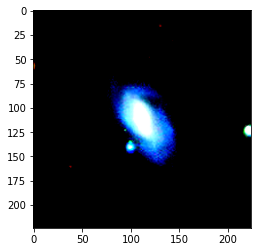

Label: 5 - Barred Spiral


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Get a batch of features and labels
train_features, train_labels = next(iter(galaxy_train_dataloader))

# Print the shape of the data
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Permute the image dimension to make plt understand it
img = train_features[0].permute(1, 2, 0).squeeze()

# Show a sample image with its corresponding label
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label} - {IDX_TO_LABELS[label.item()]}")

### Define pre-trained ResNet18 model and extract features

In [ ]:
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm

# extract_features extract some features given a pre-trained model
def extract_features(model, dataloader, return_labels=False):
  res_features, res_ys = [], []
  with torch.no_grad():
    for batch in tqdm(dataloader):
        # Get images and labels from the batch and put them into the DEVICE
        images, ys = batch
        images = images.to(DEVICE)
        if return_labels:
          ys = ys.to(DEVICE)

        # Get the output from the neural network
        outputs = model(images)
        features_to_append = []
        ys_to_append = []

        for i in range(len(outputs)):
          features_to_append.append(outputs[i].cpu().detach().numpy().reshape(-1))
        if return_labels:
          for i in range(len(ys)):
            ys_to_append.append(ys[i].item())
        else:
          for i in range(len(ys)):
            ys_to_append.append(ys[i])

        res_features.extend(features_to_append)
        res_ys.extend(ys_to_append)
  return res_features, res_ys

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
  
# Setup model
pretrained_model = models.resnet18(pretrained=True)
# Remove the last layer setting it to Identity
pretrained_model.fc = Identity()

# Put the model into our device
pretrained_model.to(DEVICE)

features, labels = extract_features(pretrained_model, galaxy_train_dataloader, True)
test_features, test_labels = extract_features(pretrained_model, galaxy_test_dataloader, True)

100%|██████████| 39/39 [00:09<00:00,  4.00it/s]


### K-NN

In [ ]:
from sklearn import neighbors

print("K-NN with pre-trained model as feature extractor")
knn_model = neighbors.KNeighborsClassifier(n_jobs=-1)

knn_model.fit(features, labels)

res = knn_model.score(test_features, test_labels)
print("Score: {:.2f}%".format(res * 100))

K-NN with pre-trained model as feature extractor
Score: 34.03%


### Random Forests

In [ ]:
from sklearn import ensemble

print("Random Forests with pre-trained model as feature extractor")
rf_model = ensemble.RandomForestClassifier()

rf_model.fit(features, labels)

res = rf_model.score(test_features, test_labels)
print("Score: {:.2f}%".format(res * 100))

Random Forests with pre-trained model as feature extractor
Score: 38.99%


### SVM

In [ ]:
from sklearn import svm

print("SVM with pre-trained model as feature extractor")
svm_model = svm.SVC()

svm_model.fit(features, labels)

res = svm_model.score(test_features, test_labels)
print("Score: {:.2f}%".format(res * 100))

SVM with pre-trained model as feature extractor
Score: 48.25%


# Neural networks

We are using the following NNs:
- **ResNet18**
- **ResNet50**


Some details:
- Epochs: 200
- Optimizer: **Adam** with initial learning rate set to 0.001
- Scheduler: **LinearWarmupCosineAnnealing** with 50 warmup epochs
- Loss Function: **CrossEntropyLoss**


## Define train and test functions + some utils

In [ ]:
# train trains the input neural network using a given dataloader and a given number of epochs
def train(net, epochs, trainDataloader, valDataloader, optimizer, scheduler, tblog=None):
  loss_function = nn.CrossEntropyLoss()
  metric_tracker = ClassificationMetrics(10)

  for epoch in range(epochs):
    # Set model to training mode
    net.train()
    # Clear the metric tracker
    metric_tracker.clear()

    print(f"-- EPOCH {epoch+1}/{epochs} -------------------------\n")

    # Iterate through trainDataloader and train the model
    i = 0
    for batch in tqdm(trainDataloader):
      # Get images and labels from the batch and put them into the DEVICE
      images, labels = batch
      images, labels = images.to(DEVICE), labels.to(DEVICE)

      # Set gradients to zero before backpropagation
      net.zero_grad()

      # Get the output from the neural network
      outputs = net(images)
      outputs.to(DEVICE)

      # Calculate the loss function
      loss = loss_function(outputs, labels)

      # The index of the largest output along the second dimension gives the predicted class label
      y = outputs.argmax(-1)
      y = y.to(DEVICE)

      # Track evaluation metrics
      metric_tracker.add(y, labels)

      # If a tensorboard summary writer is available we track the loss value
      # and the metrics of each iteration
      if tblog:
        tblog.add_scalar('train/loss', loss.item(), epoch*len(trainDataloader)+i)

      # Perform the backward pass to compute gradients
      loss.backward()
      # Update the parameters
      optimizer.step()
      i += 1

    # Print metrics accumulated over the epoch
    print("\tTRAIN | acc: {:.4f} | mAcc: {:.4f} | mIoU: {:.4f}".format(
        metric_tracker.acc(), metric_tracker.mAcc(), metric_tracker.mIoU()
    ))

    # Track the metrics in the tensorboard log
    if tblog:
      tblog.add_scalar('train/acc', metric_tracker.acc(), epoch)
      tblog.add_scalar('train/mAcc', metric_tracker.mAcc(), epoch)
      tblog.add_scalar('train/mIoU', metric_tracker.mIoU(), epoch)
      tblog.add_scalar('train/lr', scheduler.get_last_lr()[0], epoch)
    
    # Evaluate the current model
    validate(net, metric_tracker, valDataloader)

    # Print metrics over the validation set
    print("\tEVAL  | acc: {:.4f} | mAcc: {:.4f} | mIoU: {:.4f}\n".format(
        metric_tracker.acc(), 
        metric_tracker.mAcc(), metric_tracker.mIoU()
    ))

    # Track the metrics in the tensorboard log
    if tblog:
      tblog.add_scalar('val/acc', metric_tracker.acc(), epoch)
      tblog.add_scalar('val/mAcc', metric_tracker.mAcc(), epoch)
      tblog.add_scalar('val/mIoU', metric_tracker.mIoU(), epoch)

    scheduler.step()

def validate(net, metric_tracker, dataloader):
  net.eval()
  metric_tracker.clear()

  with torch.no_grad():
    for batch in tqdm(dataloader):
      images, labels = batch
      images, labels = images.to(DEVICE), labels.to(DEVICE)

      outputs = net(images)
      outputs = outputs.to(DEVICE)
      y = outputs.argmax(-1)
      y = y.to(DEVICE)
      metric_tracker.add(y, labels)

def test(model, dataloader):
  # We create the performance metric tracker
  metric_tracker = ClassificationMetrics(10)

  # We run the validation code con the test data and track the performance
  validate(model,metric_tracker, dataloader)

  # Print metrics over the test set
  print("TEST  | acc: {:.4f} | mAcc: {:.4f} | mIoU: {:.4f}\n".format(
      metric_tracker.acc(), 
      metric_tracker.mAcc(), metric_tracker.mIoU()
  ))

  return metric_tracker

In [ ]:
def write_results_to_csv(net, dataloader):
  # Open tmp csv file with results
  csv_file = open("results_tmp.csv", "w")
  writer = csv.writer(csv_file)

  # Get outputs from net
  with torch.no_grad():
    for batch in tqdm(dataloader):
      images, names = batch
      images = images.to(DEVICE)

      net_out = net(images)
      for i in range(len(names)):
        writer.writerow([names[i], IDX_TO_LABELS[torch.argmax(net_out[i]).item()]])
  csv_file.close()

  # Read the created csv
  reader = csv.reader(open("results_tmp.csv"), delimiter=",")

  # Sort the csv into a sorted_list
  sorted_list = sorted(reader, key=lambda row: int(row[0]), reverse=False)

  # Save the sorted csv in results.csv
  sorted_csv = open("results.csv", "w")
  sorted_writer = csv.writer(sorted_csv)
  for entry in sorted_list:
    sorted_writer.writerow(entry)
  sorted_csv.close()

  # Download the csv
  files.download('results.csv')

def write_sklearn_results_to_csv(model, features, names):
  # Open tmp csv file with results
  csv_file = open("results_tmp.csv", "w")
  writer = csv.writer(csv_file)

  # Get outputs from model
  for i in range(len(features)):
    model_out = model.predict(features[i].reshape(1, -1))
    writer.writerow([names[i], IDX_TO_LABELS[model_out[0]]])
  csv_file.close()

  # Read the created csv
  reader = csv.reader(open("results_tmp.csv"), delimiter=",")

  # Sort the csv into a sorted_list
  sorted_list = sorted(reader, key=lambda row: int(row[0]), reverse=False)

  # Save the sorted csv in results.csv
  sorted_csv = open("results.csv", "w")
  sorted_writer = csv.writer(sorted_csv)
  for entry in sorted_list:
    sorted_writer.writerow(entry)
  sorted_csv.close()

  # Download the csv
  files.download('results.csv')

# split_by_percentage splits the examples given a certain percentage, shuffling all_examples
def split_by_percentage(all_examples, percentage):
    how_many_examples_first_part = int(round(percentage*len(all_examples)))
    shuffled = all_examples[:]
    random.shuffle(shuffled)
    return shuffled[how_many_examples_first_part:], shuffled[:how_many_examples_first_part]

# extract_features extract some features given a pre-trained model
def extract_features(model, dataloader, return_labels=False):
  res_features, res_ys = [], []
  with torch.no_grad():
    for batch in tqdm(dataloader):
        # Get images and labels from the batch and put them into the DEVICE
        images, ys = batch
        images = images.to(DEVICE)
        if return_labels:
          ys = ys.to(DEVICE)

        # Get the output from the neural network
        outputs = model(images)
        features_to_append = []
        ys_to_append = []

        for i in range(len(outputs)):
          features_to_append.append(outputs[i].cpu().detach().numpy().reshape(-1))
        if return_labels:
          for i in range(len(ys)):
            ys_to_append.append(ys[i].item())
        else:
          for i in range(len(ys)):
            ys_to_append.append(ys[i])

        res_features.extend(features_to_append)
        res_ys.extend(ys_to_append)
  return res_features, res_ys

def run_experiment(name, model, epochs, trainDataloader, valDataloader):
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=round(epochs/4), max_epochs=epochs)
  # We create the tensorboard logger
  tblog=tb.SummaryWriter(f"exps/{name}")
  print(f"TRAINING: exps/{name}")
  # We train our model
  train(model, epochs, trainDataloader, valDataloader, optimizer, scheduler, tblog=tblog)

## Define a custom dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pn

# GalaxyDataset implements a torch Dataset, defining the __init__, the __len__ and the __getitem__ functions
class GalaxyDataset(Dataset):
    # Put all input images inside a pandas.DataFrame, set the transformation if given
    def __init__(self, images, transform=None, is_result=False):
        self.is_result = is_result
        if is_result:
          self.paths = pn.DataFrame([[i, i.split("/")[2].split(".")[0]] for i in images])
        else:
          self.paths = pn.DataFrame([[i, LABELS_TO_IDX[i.split("/")[2]]] for i in images])
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    # Open the images only in the __getitem__, so that we can have all their features one batch at a time
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Get the images names from self.paths
        img_name = self.paths.iloc[idx, 0]
        # Open the images and get their labels
        image = Image.open(img_name)
        label = self.paths.iloc[idx, 1]
        # Apply a transformation if specified
        if self.transform:
          image = self.transform(image)
        # Return a labelled example
        return image, label

## Split train and validation data

In [ ]:
from imutils import paths
import numpy as np
import os

all_examples = []
all_train_examples = []
all_val_examples = []
classes_counts = []

# Base path for our images
base_path = os.path.join("dataset", "train")

# All possible classes
classes = list(os.listdir(base_path))

# Get all examples divided by class
for galaxy_class in classes:
  class_path = os.path.join(base_path, galaxy_class)
  print(f"Found class path: {class_path}")
  to_append = list(paths.list_images(class_path))
  classes_counts.append(len(to_append))
  all_examples.append(to_append)

# Split validation and training data
for class_examples in all_examples:
  if len(class_examples) > 500:
    all_val_examples.append(class_examples[-round(len(class_examples)/100*20):])
    all_train_examples.append(class_examples[:round(len(class_examples)/100*80)])
  else:
    all_val_examples.append(class_examples[-round(len(class_examples)/100*10):])
    all_train_examples.append(class_examples[:round(len(class_examples)/100*90)])

# Get all images paths
all_train_examples = np.concatenate(all_train_examples, axis=0)
all_val_examples = np.concatenate(all_val_examples, axis=0)

print(f"\nNumber of train examples: {len(all_train_examples)}")
print(f"Number of validation examples: {len(all_val_examples)}")

Found class path: dataset/train/Unbarred Loose Spiral
Found class path: dataset/train/In-between Round Smooth
Found class path: dataset/train/Round Smooth
Found class path: dataset/train/Barred Spiral
Found class path: dataset/train/Merging
Found class path: dataset/train/Edge-on with Bulge
Found class path: dataset/train/Unbarred Tight Spiral
Found class path: dataset/train/Edge-on without Bulge
Found class path: dataset/train/Cigar Shaped Smooth
Found class path: dataset/train/Disturbed

Number of train examples: 9957
Number of validation examples: 2458


## Create datasets and dataloaders

In [ ]:
import torchvision
from torchvision import transforms

# Let's define the batch size for our neural network
BATCH_SIZE = 128

# Transforms
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transform = {
    'train': transforms.RandomChoice([
      transforms.Compose([
        transforms.RandomCrop((224, 224)),
        transforms.RandomRotation(degrees=90),
        transforms.RandomAffine(degrees=180),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.RandomVerticalFlip(p=0.4),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
      ]),
      transforms.Compose([
        transforms.CenterCrop((224, 224)),
        transforms.RandomRotation(degrees=270),
        transforms.RandomAffine(degrees=90),
        transforms.RandomPerspective(distortion_scale=0.4, p=0.1),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.GaussianBlur(9),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
      ]),
      transforms.Compose([
        transforms.RandomCrop((224, 224)),
        transforms.RandomRotation(degrees=180),
        transforms.RandomAffine(degrees=270),
        transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
      ])
    ]),
    'val': transforms.Compose([
      transforms.CenterCrop((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
    ])
}

galaxy_train_dataset = GalaxyDataset(images=all_train_examples, transform=transform['train'])
galaxy_val_dataset = GalaxyDataset(images=all_val_examples, transform=transform['val'])

# Define the weights of each class as the inverse of the class counts
weights = 1. / torch.tensor(classes_counts, dtype=torch.float)
# Get the weight of each sample
samples_weights = weights[galaxy_train_dataset.paths.iloc[:, 1]]
# Define a sampler based on the weights just defined
sampler = torch.utils.data.WeightedRandomSampler(
    weights=samples_weights,
    num_samples=len(samples_weights),
    replacement=True
)

# Train dataloader, with a sampler
loader_train = torch.utils.data.DataLoader(galaxy_train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, drop_last=False)
# Validation dataloader, we don't need the sampler
loader_val = torch.utils.data.DataLoader(galaxy_val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=False)

## Show some info about our data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])


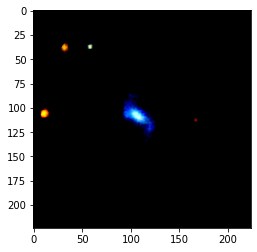

Label: 5 - Barred Spiral


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Get a batch of features and labels
train_features, train_labels = next(iter(loader_train))

# Print the shape of the data
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Permute the image dimension to make plt understand it
img = train_features[0].permute(1, 2, 0).squeeze()

# Show a sample image with its corresponding label
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label} - {IDX_TO_LABELS[label.item()]}")

## ResNet18

In [ ]:
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
import torch.utils.tensorboard as tb
import torchvision.models as models
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn

print("RESNET18\n")

# Set number of epochs for resnet18
EPOCHS = 200

print(f"Working with {DEVICE}")
print(f"Number of EPOCHS: {EPOCHS}")

print("\nCreating Model...\n")
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, 10) # 10 output classes instead of 1000
resnet18.to(DEVICE)

run_experiment("Resnet18-aug", resnet18, EPOCHS, loader_train, loader_val)

## ResNet50

In [ ]:
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn

print("RESNET50\n")

# Set number of epochs for resnet50
EPOCHS = 200

print(f"Working with {DEVICE}")
print(f"Number of EPOCHS: {EPOCHS}")

print("\nCreating Model...\n")
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(2048, 10) # 10 output classes instead of 1000
resnet50.to(DEVICE)

run_experiment("resnet50-aug", resnet50, EPOCHS, loader_train, loader_val)

## Write results

In [ ]:
all_test_examples = list(paths.list_images("dataset/test"))
galaxy_results_dataset = GalaxyDataset(images=all_test_examples, transform=transform['val'], is_result=True)
galaxy_results_dataloader = torch.utils.data.DataLoader(galaxy_results_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

write_results_to_csv(resnet18, galaxy_results_dataloader)
write_results_to_csv(resnet50, galaxy_results_dataloader)

## Open Tensorboard

In [ ]:
%tensorboard --logdir exps/

# Extra - K-NN, Random Forests and SVM with our NN as FE

After having trained our ResNet18 model, we use it as a feature extractor, and we check the accuracy we get using shallow methods.

The accuracies we see below are obtained using a ResNet18 model as feature extractor trained for 100 epochs, with the hyperparameters specified above.

## Remove the last FC layer from our NN

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

# We will use our trained resnet18 model
resnet18.fc = Identity()

# Extract features
features, labels = extract_features(resnet18, loader_train, True)
test_features, test_labels = extract_features(resnet18, loader_val, True)

100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


## K-NN

In [ ]:
from sklearn import neighbors

print("KNN")
knn_model = neighbors.KNeighborsClassifier(n_jobs=-1)

knn_model.fit(features, labels)

res = knn_model.score(test_features, test_labels)
print("Score: {:.2f}%".format(res * 100)) # 84%, 10s

KNN
Score: 82.14%


## Random Forests

In [ ]:
from sklearn import ensemble

print("Random Forests")
rf_model = ensemble.RandomForestClassifier()

rf_model.fit(features, labels)

res = rf_model.score(test_features, test_labels)
print("Score: {:.2f}%".format(res * 100)) # 84%, 30s

Random Forests
Score: 84.05%


## SVM

In [ ]:
from sklearn import svm

print("SVM")
svm_model = svm.SVC()

svm_model.fit(features, labels)

res = svm_model.score(test_features, test_labels)
print("Score: {:.2f}%".format(res * 100)) # 84%, 15s

SVM
Score: 84.70%


## Get Confusion Matrix of SVM

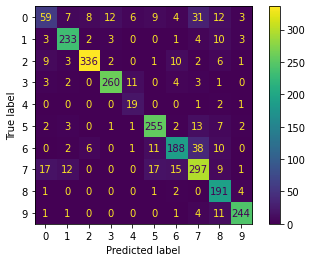

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(svm_model, test_features, test_labels)
plt.show()